In [1]:
import random
import shutil
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

# -----------------------------------
# Kaggle Setup & Data Download
# -----------------------------------


# Install Kaggle API
!pip install kaggle --quiet

# -----------medical-mnist--------------
# !kaggle datasets download -d andrewmvd/medical-mnist
# !unzip -q medical-mnist.zip -d medical_mnist_data

# --------------natural-images------------
!kaggle datasets download -d prasunroy/natural-images
!unzip -q natural-images.zip -d natural_images_data




Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images
License(s): CC-BY-NC-SA-4.0
 94% 321M/342M [00:02<00:00, 161MB/s]
100% 342M/342M [00:02<00:00, 145MB/s]


In [2]:
import os

# -----------------------------------
# Parameters and Paths
# -----------------------------------
# data_dir = "medical_mnist_data/"
# split_base = "medical_mnist_split"


data_dir = "natural_images_data/natural_images"
split_base = "natural_images_split"


img_height, img_width = 224, 224
batch_size = 32
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
seed = 42

# -----------------------------------
# Prepare Dataset Splits
# -----------------------------------
root_dir = data_dir
classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]


if os.path.exists(split_base):
    shutil.rmtree(split_base)
os.makedirs(split_base, exist_ok=True)

train_dir = os.path.join(split_base, "train")
val_dir = os.path.join(split_base, "val")
test_dir = os.path.join(split_base, "test")

for c in classes:
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(val_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)

for c in classes:
    class_path = os.path.join(root_dir, c)
    images = glob.glob(os.path.join(class_path, "*.*"))  # picks up all files
    random.seed(seed)
    random.shuffle(images)
    total = len(images)
    train_count = int(train_ratio * total)
    val_count = int(val_ratio * total)
    test_count = total - train_count - val_count

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    for img in train_images:
        shutil.copy(img, os.path.join(train_dir, c))
    for img in val_images:
        shutil.copy(img, os.path.join(val_dir, c))
    for img in test_images:
        shutil.copy(img, os.path.join(test_dir, c))

# -----------------------------------
# Create Datasets
# -----------------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 4826 files belonging to 8 classes.
Found 1032 files belonging to 8 classes.
Found 1041 files belonging to 8 classes.


In [27]:
# -----------------------------------
# Define AlexNet-like Architecture
# -----------------------------------
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),

    layers.Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    layers.Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    layers.Conv2D(filters=192, kernel_size=(3,3), padding='same', activation='relu'),
    # layers.Conv2D(filters=192, kernel_size=(3,3), padding='same', activation='relu'),

    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    # layers.Dense(num_classes, activation='softmax')
    layers.Dense(num_classes, activation='linear')

])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    # loss='sparse_categorical_crossentropy',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 54, 54, 64)          │          23,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 26, 26, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 12, 12, 192)         │         221,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 12, 12, 128)         │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1024)                │       3,277,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,478,408 (17.08 MB)

 Trainable params: 4,478,024 (17.08 MB)

 Non-trainable params: 384 (1.50 KB)

In [28]:
# -----------------------------------
# Train the Model
# -----------------------------------
epochs = 20
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)


Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.3813 - loss: 1.9484 - val_accuracy: 0.6705 - val_loss: 0.9390
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7624 - loss: 0.6729 - val_accuracy: 0.7917 - val_loss: 0.5424
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4360 - val_accuracy: 0.4903 - val_loss: 1.5956
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8661 - loss: 0.3779 - val_accuracy: 0.8605 - val_loss: 0.3445
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8945 - loss: 0.2985 - val_accuracy: 0.8740 - val_loss: 0.3313
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9083 - loss: 0.2463 - val_accuracy: 0.8149 - val_loss: 0.5060
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9276 - loss: 0.2054 - val_accuracy: 0.8488 - val_loss: 0.4497
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9402 - loss: 0.1725 - val_accuracy: 

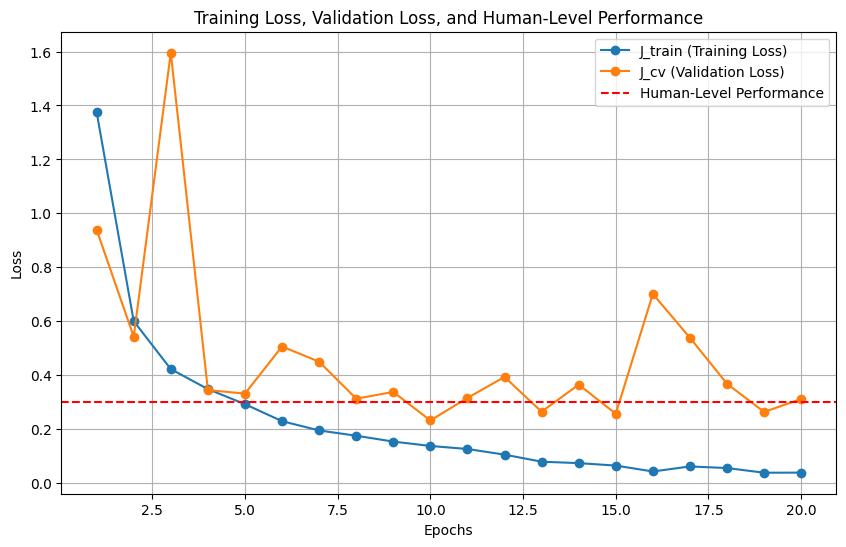

In [31]:
import matplotlib.pyplot as plt

# Access training and validation loss
J_train = history.history['loss']  # Training loss for all epochs
J_cv = history.history['val_loss']  # Validation loss for all epochs

# Human-Level Loss (assumed value)
human_level_loss = 0.3

# Plot the losses
epochs_range = range(1, len(J_train) + 1)
plt.figure(figsize=(10, 6))

plt.plot(epochs_range, J_train, label='J_train (Training Loss)', marker='o')
plt.plot(epochs_range, J_cv, label='J_cv (Validation Loss)', marker='o')
plt.axhline(y=human_level_loss, color='r', linestyle='--', label='Human-Level Performance')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss, Validation Loss, and Human-Level Performance')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# -----------------------------------
# Evaluate on Test Set
# -----------------------------------
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

# -----------------------------------
# Classification Report
# -----------------------------------
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    y_pred.extend(preds.tolist())
    y_true.extend(labels.numpy().tolist())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9259 - loss: 0.2497
Test accuracy: 0.9260326623916626
Classification Report:
              precision    recall  f1-score   support

    airplane       0.94      0.98      0.96       110
         car       0.94      0.99      0.96       146
         cat       0.74      0.87      0.80       134
         dog       0.86      0.60      0.71       106
      flower       0.97      0.89      0.93       127
       fruit       0.99      1.00      1.00       150
   motorbike       0.98      1.00      0.99       119
      person       0.98      1.00      0.99       149

    accuracy                           0.93      1041
   macro avg       0.93      0.92      0.92      1041
weighted avg       0.93      0.93      0.92      1041

